In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import whois
from datetime import datetime
from urllib.parse import urlparse
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import joblib

In [5]:
#df = pd.read_csv('top-1m.csv')

In [22]:
# import pandas as pd
# import requests
# import zipfile
# import io

# def get_benign_urls(num_urls=1000):
#     print("Downloading Tranco Top 1M list...")
#     # URL for the latest daily list
#     url = "https://tranco-list.eu/top-1m.csv.zip"
    
#     response = requests.get(url)
#     with zipfile.ZipFile(io.BytesIO(response.content)) as z:
#         # The zip contains a single CSV file
#         filename = z.namelist()[0]
#         with z.open(filename) as f:
#             # Read only the first 'num_urls' rows
#             # Tranco CSV format is: Rank, Domain
#             df = pd.read_csv(f, header=None, names=['rank', 'url'], nrows=num_urls)
    
#     # Add 'https://' to make them valid URLs for your scraper
#     df['url'] = 'https://' + df['url']
#     df['label'] = 'benign'
    
#     # Save to CSV
#     output_file = 'benign_urls.csv'
#     df.to_csv(output_file, index=False)
#     print(f"Success! Saved {num_urls} benign URLs to '{output_file}'")
#     print(df.head())

# if __name__ == "__main__":
#     get_benign_urls(1010)

Success! Saved 1010 benign URLs to 'benign_urls.csv'
   rank                       url   label
0     1        https://google.com  benign
1     2     https://microsoft.com  benign
2     3           https://mail.ru  benign
3     4      https://facebook.com  benign
4     5  https://gtld-servers.net  benign


In [24]:
# # 1. Load the data
# df_benign = pd.read_csv('benign_urls.csv')
# # Adjust 'manual_phishing_urls.csv' to whatever your file is named
# # 'header=None' assumes your pasted file has no header row
# df_phishing = pd.read_csv('phishing_urls.csv', header=None, names=['url'])

# # 2. Add labels
# df_benign['label'] = 'benign'
# df_phishing['label'] = 'phishing'

# # 3. Limit to balance classes (assuming you have ~1000 of each)
# # Adjust n=1000 if you have fewer phishing URLs
# df_benign = df_benign.sample(n=len(df_phishing), random_state=42)

# # 4. Combine and Shuffle
# df_final = pd.concat([df_benign, df_phishing], ignore_index=True)
# df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

# # 5. Check and Save
# print(df_final['label'].value_counts())
# df_final.to_csv('final_dataset_2k.csv', index=False)
# print("Saved final_dataset_2k.csv")

label
benign      1010
phishing    1010
Name: count, dtype: int64
Saved final_dataset_2k.csv


In [28]:
df = pd.read_csv('final_dataset_2k.csv')

In [29]:
df

,rank,url,label
0,803.0,https://washington.edu,benign
1,604.0,https://vkontakte.ru,benign
2,42.0,https://fastly.net,benign
3,NaN,https://dbsbyccdigitalinfoid.univer.se/,phishing
4,NaN,https://www.bigcplatform.com,phishing
...,...,...,...
2015,NaN,https://ripio-acceso.begin-auth.com,phishing
2016,NaN,https://tubular-kangaroo-2e6b49.netlify.app/so...,phishing
2017,840.0,https://afilias-nst.info,benign
2018,NaN,https://app.acuityscheduling.com/schedule/c23a...,phishing


In [30]:
def analyze_redirects(start_url):
    """
    Takes a single starting URL, follows its redirect chain, 
    and extracts features from the journey.
    
    Returns:
        - The final destination URL (str)
        - A dictionary of Layer 2 features (dict)
    """
    # These are the default "error" values if anything fails
    l2_features = {
        'hop_count': -1,
        'final_domain_age_days': -1,
        'uses_url_shortener': 0
    }
    
    redirect_chain = []
    current_url = start_url
    max_hops = 10 # Safety limit to prevent infinite loops
    
    # 1. Check for common URL shorteners
    try:
        parsed_start_url = urlparse(start_url)
        # Add more shorteners to this list as you find them
        shorteners = ['bit.ly', 'tinyurl.com', 't.co', 'goo.gl', 'buff.ly']
        if parsed_start_url.netloc in shorteners:
            l2_features['uses_url_shortener'] = 1
    except Exception as e:
        # print(f"URL parse error: {e}")
        pass # Ignore errors on malformed URLs

    # 2. Follow the redirect chain
    try:
        for i in range(max_hops):
            # We use a HEAD request: it's faster, we only need the headers.
            # We must set allow_redirects=False to handle it ourselves.
            response = requests.head(current_url, allow_redirects=False, timeout=5, headers={
                # We pretend to be a real browser to avoid being blocked (403 Forbidden)
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
            })
            
            redirect_chain.append(current_url)

            # Check if it's a redirect (status codes 301, 302, 307, 308)
            if 300 <= response.status_code < 400 and 'Location' in response.headers:
                next_url = response.headers['Location']
                
                # Handle relative URLs (e.g., /login.php)
                if not urlparse(next_url).netloc:
                    next_url = requests.compat.urljoin(current_url, next_url)
                
                current_url = next_url
            else:
                # This is the final destination (or an error)
                break
        
        l2_features['hop_count'] = len(redirect_chain) - 1 # The first URL isn't a "hop"

    except requests.exceptions.RequestException as e:
        # print(f"L2 Error (Request): {e}")
        return None, l2_features # Failed to follow chain

    # 3. Get domain age of the *final* URL
    final_url = current_url
    try:
        domain = urlparse(final_url).netloc
        if domain:
            domain_info = whois.whois(domain)
            creation_date = domain_info.creation_date
            
            if isinstance(creation_date, list): # Handle inconsistent whois data
                creation_date = creation_date[0]
            
            if creation_date:
                age = (datetime.now() - creation_date).days
                l2_features['final_domain_age_days'] = age
            else:
                l2_features['final_domain_age_days'] = -1 # Age not found in record
        else:
            l2_features['final_domain_age_days'] = -1 # Could not parse domain
            
    except Exception as e:
        # WHOIS lookups fail often (rate limits, weird domains). This is normal.
        # print(f"L2 Error (WHOIS): {e}")
        l2_features['final_domain_age_days'] = -1 

    return final_url, l2_features


In [31]:

print("Layer 2 function 'analyze_redirects' is defined.")

# --- Cell [3]: **LAYER 2 DEBUGGING CELL** ---
# This is where you test your L2 function in isolation.
# Run this cell to see if the function works as expected.

print("--- Testing Layer 2: analyze_redirects ---")

# Test 1: A normal, non-redirecting, old domain
url1 = "https://google.com"
final_url_1, features_1 = analyze_redirects(url1)
print(f"\nTest 1 (Safe): {url1}")
print(f" -> Final URL: {final_url_1}")
print(f" -> Features: {features_1}")

# Test 2: A shortened URL
url2 = "http://bit.ly/google"
final_url_2, features_2 = analyze_redirects(url2)
print(f"\nTest 2 (Shortener): {url2}")
print(f" -> Final URL: {final_url_2}")
print(f" -> Features: {features_2}")

# Test 3: A test phishing link
url3 = "http://testsafebrowsing.appspot.com/s/phishing.html"
final_url_3, features_3 = analyze_redirects(url3)
print(f"\nTest 3 (Test Phish): {url3}")
print(f" -> Final URL: {final_url_3}")
print(f" -> Features: {features_3}")

Layer 2 function 'analyze_redirects' is defined.
--- Testing Layer 2: analyze_redirects ---

Test 1 (Safe): https://google.com
 -> Final URL: https://www.google.com/
 -> Features: {'hop_count': 1, 'final_domain_age_days': -1, 'uses_url_shortener': 0}

Test 2 (Shortener): http://bit.ly/google
 -> Final URL: https://get.google.com/albumarchive/pwa/CamenzindEvolution/NewGoogleOfficeZurich?pli=1
 -> Features: {'hop_count': 3, 'final_domain_age_days': -1, 'uses_url_shortener': 1}

Test 3 (Test Phish): http://testsafebrowsing.appspot.com/s/phishing.html
 -> Final URL: http://testsafebrowsing.appspot.com/s/phishing.html
 -> Features: {'hop_count': 0, 'final_domain_age_days': -1, 'uses_url_shortener': 0}


In [32]:
def analyze_html(url):
    """
    Takes a single final URL, fetches its HTML, and extracts
    structural features.
    
    Returns:
        - A dictionary of Layer 3 features (dict)
    """
    # Default "error" values
    l3_features = {
        'num_script_tags': -1,
        'has_password_field': -1,
        'num_external_links': -1,
        'dom_depth': -1
    }
    
    if not url:
        return l3_features # Can't analyze a non-existent URL

    try:
        # This time, we use GET to fetch the full page content
        response = requests.get(url, timeout=10, headers={
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        })
        
        # Raise an error if the page was 404, 500, etc.
        response.raise_for_status() 
        
        soup = BeautifulSoup(response.content, 'html.parser')

        # 1. Feature: Number of <script> tags
        l3_features['num_script_tags'] = len(soup.find_all('script'))
        
        # 2. Feature: Has a password field?
        l3_features['has_password_field'] = 1 if soup.find('input', {'type': 'password'}) else 0
        
        # 3. Feature: Number of external links
        external_links = 0
        current_domain = urlparse(url).netloc
        for link in soup.find_all('a', href=True):
            link_domain = urlparse(link['href']).netloc
            # If the link has a domain and it's not our current domain
            if link_domain and link_domain != current_domain:
                external_links += 1
        l3_features['num_external_links'] = external_links
        
        # 4. Feature (Novelty): Max DOM Depth
        def get_depth(element, depth):
            if not hasattr(element, 'children'):
                return depth
            max_child_depth = depth
            for child in element.children:
                if child.name: # Only count actual tags, not text nodes
                    child_depth = get_depth(child, depth + 1)
                    if child_depth > max_child_depth:
                        max_child_depth = child_depth
            return max_child_depth
        
        l3_features['dom_depth'] = get_depth(soup, 0)

    except requests.exceptions.RequestException as e:
        # print(f"L3 Error (Request): {e}")
        pass # Return the default error values
    except Exception as e:
        # print(f"L3 Error (Parsing): {e}")
        pass # Return the default error values

    return l3_features

In [33]:
print("Layer 3 function 'analyze_html' is defined.")

# --- Cell [5]: **LAYER 3 DEBUGGING CELL** ---
# This is where you test your L3 function in isolation.

print("\n--- Testing Layer 3: analyze_html ---")

# Test 1: Google (complex, many scripts, no password)
url1 = "https://google.com"
features_1 = analyze_html(url1)
print(f"\nTest 1 (Safe): {url1}")
print(f" -> Features: {features_1}")

# Test 2: Phishing test site (simple, has password)
url2 = "http://testsafebrowsing.appspot.com/s/phishing.html"
features_2 = analyze_html(url2)
print(f"\nTest 2 (Test Phish): {url2}")
print(f" -> Features: {features_2}")


Layer 3 function 'analyze_html' is defined.

--- Testing Layer 3: analyze_html ---

Test 1 (Safe): https://google.com
 -> Features: {'num_script_tags': 6, 'has_password_field': 0, 'num_external_links': 8, 'dom_depth': 11}

Test 2 (Test Phish): http://testsafebrowsing.appspot.com/s/phishing.html
 -> Features: {'num_script_tags': 0, 'has_password_field': 1, 'num_external_links': 0, 'dom_depth': 5}


In [35]:
def process_urls_to_features(df):
    """
    Orchestrates the full L2/L3 pipeline for an entire DataFrame of URLs.
    
    Args:
        df: A DataFrame with at least 'url' and 'type' (or 'label') columns.
        
    Returns:
        A new DataFrame containing all the extracted features.
    """
    total_urls = len(df)
    print(f"Starting feature extraction for {total_urls} URLs...")
    
    # This list will hold all our feature dictionaries
    results_list = []
    
    # We use .iterrows() to loop through the DataFrame
    for index, row in df.iterrows():
        start_url = row['url']
        label = row['type'] # Get the label (e.g., 'phishing', 'benign')
        
        # --- Run the Pipeline ---
        final_url, l2_features = analyze_redirects(start_url)
        l3_features = analyze_html(final_url)
        # ------------------------
        
        # Combine all features into one dictionary
        combined_features = {
            'original_url': start_url,
            'label': label,
            **l2_features,
            **l3_features
        }
        
        # Add the result to our list
        results_list.append(combined_features)
        
        # --- CRITICAL: Be a polite scraper! ---
        # A small delay prevents us from getting IP-banned by servers.
        time.sleep(0.05) # 50 milliseconds
        
        if (index + 1) % 50 == 0:
            print(f"--- Processed {index + 1}/{total_urls} URLs ---")
            
    print(f"\nDone! Feature extraction complete for {total_urls} URLs.")
    
    # Convert our list of dictionaries into a new DataFrame
    results_df = pd.DataFrame(results_list)
    return results_df


In [36]:
print("Main orchestrator function 'process_urls_to_features' is defined.")

# --- Cell [7]: **THE MAIN RUN CELL** ---
# This is the final step. We load our real data, take a SMALL
# sample, and run our full pipeline on it.

# **IMPORTANT!**
# Your full dataset has 650,000+ URLs. Running the scraper on all
# of them will take *DAYS*. We will test with a small sample first.
NUM_URLS_TO_TEST = 100 

print(f"--- STARTING MAIN RUN (SAMPLE of {NUM_URLS_TO_TEST} URLs) ---")

# 1. Define file paths
input_csv_path = 'malicious_phish.csv' # The file you downloaded from Kaggle
output_csv_path = 'spearphish_features.csv' # The file we will create

# 2. Load the input CSV
try:
    df_full = pd.read_csv(input_csv_path)
    print(f"Loaded {len(df_full)} total URLs from {input_csv_path}")
except FileNotFoundError:
    print(f"ERROR: Input file not found at {input_csv_path}")
    print("Please download the 'Malicious URLs dataset' from Kaggle,")
    print("unzip it, and rename it to 'malicious_phish.csv' in the same folder.")
    # Stop the notebook from running further
    raise

# 3. Create a small, random sample for testing
# (Comment this line out when you are ready to run the full script overnight)
df_sample = df_full.sample(n=NUM_URLS_TO_TEST, random_state=42)
print(f"Created a sample of {len(df_sample)} URLs to process.")

# 4. Run the full pipeline on our sample
processed_df = process_urls_to_features(df)

# 5. Show the results
print("\n--- Sample of Generated Feature Dataset ---")
pd.set_option('display.max_columns', None) # Show all columns
print(processed_df.head())

# 6. Save the results to our new CSV
try:
    processed_df.to_csv(output_csv_path, index=False, encoding='utf-8')
    print(f"\nSuccessfully saved {len(processed_df)} rows of features to {output_csv_path}")
except Exception as e:
    print(f"Error saving file: {e}")

print("\n--- SCRIPT COMPLETE ---")
print("To run the full dataset (650k+ URLs), comment out the 'df_sample' line.")
print("Be aware this will take a very long time (many hours or days).")

Main orchestrator function 'process_urls_to_features' is defined.
--- STARTING MAIN RUN (SAMPLE of 100 URLs) ---
Loaded 651191 total URLs from malicious_phish.csv
Created a sample of 100 URLs to process.
Starting feature extraction for 2020 URLs...


KeyError: 'type'

In [11]:
print(processed_df.head(15))

                                         original_url       label  hop_count  \
0              http://37.49.226.178/deusbins/deus.sh4     malware          0   
1   medical-dictionary.thefreedictionary.com/Galt+...      benign         -1   
2                          www.jscape.com/sshfactory/    phishing         -1   
3   http://www.wsnc.org.au/component/jcalpro/view/983  defacement          1   
4   virtualtourist.com/travel/North_America/Canada...      benign         -1   
5              evri.com/person/donald-ballard-0x87e96      benign         -1   
6   http://www.sweethome.com.gr/index.php?option=c...  defacement         -1   
7                       www.msnbc.msn.com/?id=3475953    phishing         -1   
8   http://www.mruniquespaving.co.uk/paved-drivewa...  defacement         -1   
9   http://torcache.net/torrent/4646B1C156C01B1D1B...      benign          0   
10                     cartoonfactory.com/history.asp      benign         -1   
11  pahdb.mcgill.ca/?Topic=Information&S

In [14]:
processed_df.head()

,original_url,label,hop_count,final_domain_age_days,uses_url_shortener,num_script_tags,has_password_field,num_external_links,dom_depth
0,http://37.49.226.178/deusbins/deus.sh4,malware,0,-1,0,0,0,1,10
1,medical-dictionary.thefreedictionary.com/Galt+...,benign,-1,-1,0,-1,-1,-1,-1
2,www.jscape.com/sshfactory/,phishing,-1,-1,0,-1,-1,-1,-1
3,http://www.wsnc.org.au/component/jcalpro/view/983,defacement,1,-1,0,-1,-1,-1,-1
4,virtualtourist.com/travel/North_America/Canada...,benign,-1,-1,0,-1,-1,-1,-1


In [37]:
# --- Helper Functions ---
def get_tld(url):
    try:
        domain = urlparse(url).netloc
        if not domain: return 'none'
        parts = domain.split('.')
        if len(parts) > 1:
            return '.'.join(parts[-2:]) if len(parts[-1]) == 2 and len(parts[-2]) <= 3 else parts[-1]
        return 'none'
    except: return 'error'

# --- Layer 2: Redirect Analyzer (Updated with TLD) ---
def analyze_redirects(start_url):
    l2_features = {
        'hop_count': -1,
        'final_domain_age_days': -1,
        'uses_url_shortener': 0,
        'final_url_tld': 'none' # <--- NEW FEATURE
    }
    
    redirect_chain = []
    current_url = str(start_url)
    max_hops = 10 
    
    # 1. Check Shortener
    try:
        if urlparse(current_url).netloc in ['bit.ly', 'tinyurl.com', 't.co', 'goo.gl']:
            l2_features['uses_url_shortener'] = 1
    except: pass 

    # 2. Follow Redirects
    try:
        for i in range(max_hops):
            response = requests.head(current_url, allow_redirects=False, timeout=3, headers={
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
            })
            redirect_chain.append(current_url)
            if 300 <= response.status_code < 400 and 'Location' in response.headers:
                next_url = response.headers['Location']
                if not urlparse(next_url).netloc:
                    next_url = requests.compat.urljoin(current_url, next_url)
                current_url = next_url
            else:
                break
        l2_features['hop_count'] = len(redirect_chain) - 1
    except: 
        return None, l2_features 

    # 3. Final URL Analysis
    final_url = current_url
    l2_features['final_url_tld'] = get_tld(final_url)
    
    # Try WHOIS (It's okay if this fails)
    try:
        domain = urlparse(final_url).netloc
        if domain:
            domain_info = whois.whois(domain)
            creation_date = domain_info.creation_date
            if isinstance(creation_date, list): creation_date = creation_date[0]
            if creation_date:
                l2_features['final_domain_age_days'] = (datetime.now() - creation_date).days
    except: pass

    return final_url, l2_features

# --- Main Orchestrator (Fixed Column Name) ---
def process_urls_to_features(df):
    total_urls = len(df)
    print(f"Starting extraction for {total_urls} URLs...")
    results_list = []
    
    for index, row in df.iterrows():
        start_url = row['url']
        # FIX: Changed row['type'] to row['label'] to match your new df
        label = row['label'] 
        
        final_url, l2_features = analyze_redirects(start_url)
        
        # Only run HTML analysis if Redirect analysis didn't crash entirely
        if final_url:
            l3_features = analyze_html(final_url)
        else:
            # Fill L3 with errors if L2 failed
            l3_features = {'num_script_tags': -1, 'has_password_field': -1, 'num_external_links': -1, 'dom_depth': -1}

        combined = {
            'original_url': start_url,
            'label': label,
            **l2_features,
            **l3_features
        }
        results_list.append(combined)
        
        # Progress bar
        if (index + 1) % 50 == 0:
            print(f"Processed {index + 1}/{total_urls}")
            
    return pd.DataFrame(results_list)

In [99]:
hope = pd.read_csv('spearphish_features.csv')

In [100]:
hope.describe()

,hop_count,final_domain_age_days,uses_url_shortener,num_script_tags,has_password_field,num_external_links,dom_depth
count,2020.000000,2020.0,2020.000000,2020.000000,2020.000000,2020.00000,2020.000000
mean,0.029703,-1.0,0.002475,8.732673,-0.520792,11.39604,6.408416
std,1.094861,0.0,0.049703,20.306635,0.536035,48.87299,9.939890
min,-1.000000,-1.0,0.000000,-1.000000,-1.000000,-1.00000,-1.000000
25%,-1.000000,-1.0,0.000000,-1.000000,-1.000000,-1.00000,-1.000000
50%,0.000000,-1.0,0.000000,-1.000000,-1.000000,-1.00000,-1.000000
75%,1.000000,-1.0,0.000000,9.000000,0.000000,3.00000,13.000000
max,9.000000,-1.0,1.000000,269.000000,1.000000,916.00000,51.000000


In [101]:
(hope['final_domain_age_days'] > 0).sum()

np.int64(0)

--- Link Rot Analysis ---
label     status 
benign    Failed     318
          Success    692
phishing  Failed     454
          Success    556
dtype: int64


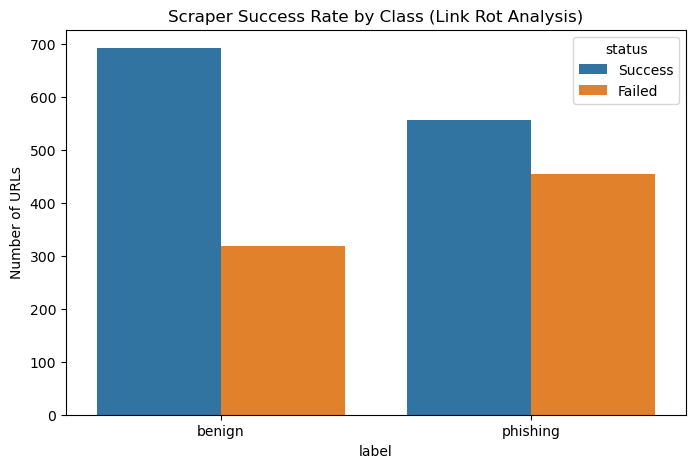


--- Live Data Analysis (n=1248) ---


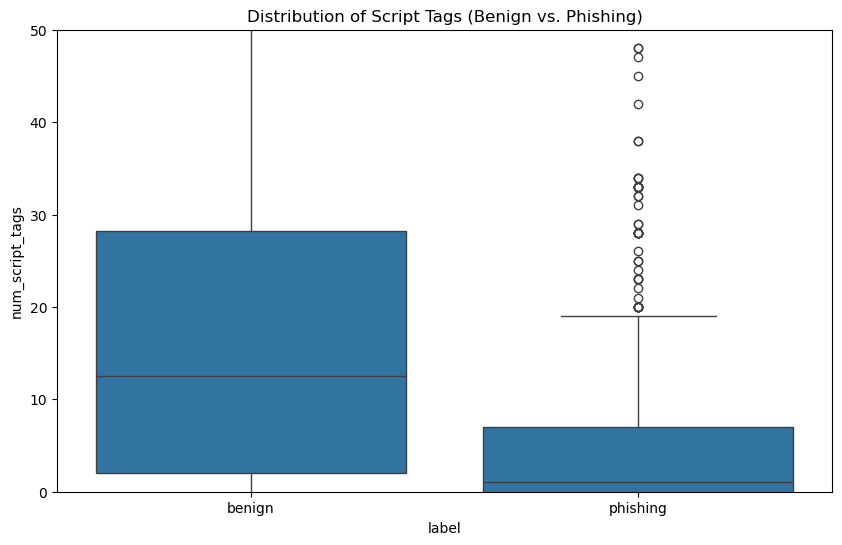

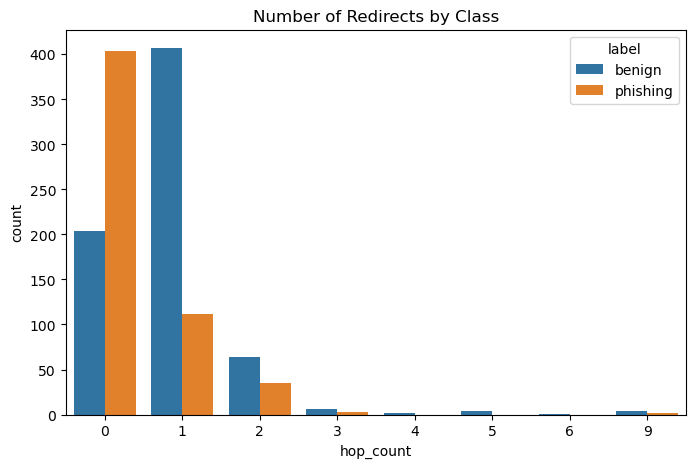


--- Feature Variance Check ---
Column 'original_url' is good (unique values: 2019)
Column 'label' is good (unique values: 2)
Column 'hop_count' is good (unique values: 9)
Column 'uses_url_shortener' is good (unique values: 2)
Column 'final_url_tld' is good (unique values: 137)
Column 'num_script_tags' is good (unique values: 100)
Column 'has_password_field' is good (unique values: 3)
Column 'num_external_links' is good (unique values: 124)
Column 'dom_depth' is good (unique values: 46)
Column 'status' is good (unique values: 2)


In [102]:
# 1. Load Data
df = pd.read_csv('spearphish_features.csv')

# --- Analysis 1: Link Rot (Success vs. Failure) ---
# Create a 'status' column: 'Success' if hop_count != -1, else 'Failed'
df['status'] = df['hop_count'].apply(lambda x: 'Success' if x != -1 else 'Failed')

print("--- Link Rot Analysis ---")
print(df.groupby(['label', 'status']).size())

# Visualization 1: Link Rot Bar Chart
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='label', hue='status')
plt.title('Scraper Success Rate by Class (Link Rot Analysis)')
plt.ylabel('Number of URLs')
plt.savefig('link_rot_analysis.png')
plt.show()

# --- Analysis 2: Feature Distribution (Live Sites Only) ---
# Filter for successful scrapes only
df_live = df[df['status'] == 'Success'].copy()

print(f"\n--- Live Data Analysis (n={len(df_live)}) ---")

# Visualization 2: Script Tags Distribution
# (We limit x-axis because some sites have 1000s of scripts, skewing the plot)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_live, x='label', y='num_script_tags')
plt.ylim(0, 50) # Zoom in to see the difference
plt.title('Distribution of Script Tags (Benign vs. Phishing)')
plt.savefig('script_tags_dist.png')
plt.show()

# Visualization 3: Redirect Hops
plt.figure(figsize=(8, 5))
sns.countplot(data=df_live, x='hop_count', hue='label')
plt.title('Number of Redirects by Class')
plt.savefig('redirects_dist.png')
plt.show()

# --- Analysis 3: Missing/Useless Features ---
# Check for columns with single values (zero variance)
print("\n--- Feature Variance Check ---")
for col in df.columns:
    if df[col].nunique() <= 1:
        print(f"WARNING: Column '{col}' has zero variance (all values are the same). DROP IT.")
    else:
        print(f"Column '{col}' is good (unique values: {df[col].nunique()})")

In [103]:
df

,original_url,label,hop_count,final_domain_age_days,uses_url_shortener,final_url_tld,num_script_tags,has_password_field,num_external_links,dom_depth,status
0,https://washington.edu,benign,1,-1,0,edu,15,0,62,13,Success
1,https://vkontakte.ru,benign,0,-1,0,ru,50,0,0,7,Success
2,https://fastly.net,benign,1,-1,0,com,16,0,14,20,Success
3,https://dbsbyccdigitalinfoid.univer.se/,phishing,0,-1,0,se,-1,-1,-1,-1,Success
4,https://www.bigcplatform.com,phishing,-1,-1,0,none,-1,-1,-1,-1,Failed
...,...,...,...,...,...,...,...,...,...,...,...
2015,https://ripio-acceso.begin-auth.com,phishing,-1,-1,0,none,-1,-1,-1,-1,Failed
2016,https://tubular-kangaroo-2e6b49.netlify.app/so...,phishing,0,-1,0,app,-1,-1,-1,-1,Success
2017,https://afilias-nst.info,benign,-1,-1,0,none,-1,-1,-1,-1,Failed
2018,https://app.acuityscheduling.com/schedule/c23a...,phishing,0,-1,0,com,6,0,0,8,Success


In [104]:
df['status'].value_counts()

status
Success    1248
Failed      772
Name: count, dtype: int64

In [105]:
df.columns

Index(['original_url', 'label', 'hop_count', 'final_domain_age_days',
       'uses_url_shortener', 'final_url_tld', 'num_script_tags',
       'has_password_field', 'num_external_links', 'dom_depth', 'status'],
      dtype='object')

In [106]:
df.describe()

,hop_count,final_domain_age_days,uses_url_shortener,num_script_tags,has_password_field,num_external_links,dom_depth
count,2020.000000,2020.0,2020.000000,2020.000000,2020.000000,2020.00000,2020.000000
mean,0.029703,-1.0,0.002475,8.732673,-0.520792,11.39604,6.408416
std,1.094861,0.0,0.049703,20.306635,0.536035,48.87299,9.939890
min,-1.000000,-1.0,0.000000,-1.000000,-1.000000,-1.00000,-1.000000
25%,-1.000000,-1.0,0.000000,-1.000000,-1.000000,-1.00000,-1.000000
50%,0.000000,-1.0,0.000000,-1.000000,-1.000000,-1.00000,-1.000000
75%,1.000000,-1.0,0.000000,9.000000,0.000000,3.00000,13.000000
max,9.000000,-1.0,1.000000,269.000000,1.000000,916.00000,51.000000


In [107]:
df

,original_url,label,hop_count,final_domain_age_days,uses_url_shortener,final_url_tld,num_script_tags,has_password_field,num_external_links,dom_depth,status
0,https://washington.edu,benign,1,-1,0,edu,15,0,62,13,Success
1,https://vkontakte.ru,benign,0,-1,0,ru,50,0,0,7,Success
2,https://fastly.net,benign,1,-1,0,com,16,0,14,20,Success
3,https://dbsbyccdigitalinfoid.univer.se/,phishing,0,-1,0,se,-1,-1,-1,-1,Success
4,https://www.bigcplatform.com,phishing,-1,-1,0,none,-1,-1,-1,-1,Failed
...,...,...,...,...,...,...,...,...,...,...,...
2015,https://ripio-acceso.begin-auth.com,phishing,-1,-1,0,none,-1,-1,-1,-1,Failed
2016,https://tubular-kangaroo-2e6b49.netlify.app/so...,phishing,0,-1,0,app,-1,-1,-1,-1,Success
2017,https://afilias-nst.info,benign,-1,-1,0,none,-1,-1,-1,-1,Failed
2018,https://app.acuityscheduling.com/schedule/c23a...,phishing,0,-1,0,com,6,0,0,8,Success


In [108]:
df[df['hop_count'] != -1]

,original_url,label,hop_count,final_domain_age_days,uses_url_shortener,final_url_tld,num_script_tags,has_password_field,num_external_links,dom_depth,status
0,https://washington.edu,benign,1,-1,0,edu,15,0,62,13,Success
1,https://vkontakte.ru,benign,0,-1,0,ru,50,0,0,7,Success
2,https://fastly.net,benign,1,-1,0,com,16,0,14,20,Success
3,https://dbsbyccdigitalinfoid.univer.se/,phishing,0,-1,0,se,-1,-1,-1,-1,Success
6,https://rlsbb.to/,phishing,0,-1,0,to,20,0,409,23,Success
...,...,...,...,...,...,...,...,...,...,...,...
2010,https://playrix.com,benign,0,-1,0,com,4,0,0,4,Success
2012,https://aumentecentral.s3.us-east-005.backblaz...,phishing,0,-1,0,com,-1,-1,-1,-1,Success
2013,http://meta-prime-egn.pages.dev,phishing,0,-1,0,dev,-1,-1,-1,-1,Success
2016,https://tubular-kangaroo-2e6b49.netlify.app/so...,phishing,0,-1,0,app,-1,-1,-1,-1,Success


In [109]:
df_clean = df[df['hop_count'] != -1].copy()

cols_to_drop = ['final_domain_age_days', 'original_url', 'status']

df_clean = df_clean.drop(columns=[c for c in cols_to_drop if c in df_clean.columns])

In [110]:
df['final_url_tld'].value_counts()

final_url_tld
none      772
com       715
org        55
net        37
app        37
         ... 
com.hk      1
fr:443      1
ma          1
care        1
pt          1
Name: count, Length: 137, dtype: int64

In [111]:
tld_encoder = LabelEncoder()
df_clean['final_url_tld'] = tld_encoder.fit_transform(df_clean['final_url_tld'].astype(str))

In [112]:
X = df_clean.drop(columns=['label'])

In [116]:
# 1. Load Data
# (Assuming you have 'df' in memory, otherwise: df = pd.read_csv('spearphish_features.csv'))
# For this snippet, I'll assume 'df' is your raw dataframe from the previous step

# 2. Filter: Drop failed scrapes
print(f"Original count: {len(df)}")
df_clean = df[df['hop_count'] != -1].copy()
print(f"Clean count (successes only): {len(df_clean)}")

# 3. Drop Useless Columns
cols_to_drop = ['final_domain_age_days', 'original_url', 'status']
# Only drop if they exist
df_clean = df_clean.drop(columns=[c for c in cols_to_drop if c in df_clean.columns])

# 4. Encode TLD (Frequency Encoding Strategy)
# Calculate counts
tld_counts = df_clean['final_url_tld'].value_counts()
# Map counts to the dataframe (Replacing the string with the count)
df_clean['final_url_tld_freq'] = df_clean['final_url_tld'].map(tld_counts)
# Drop the original string column
df_clean = df_clean.drop(columns=['final_url_tld'])

# 5. Define Target (y)
# Map 'phishing' to 1, 'benign' to 0
y = df_clean['label'].map({'phishing': 1, 'benign': 0})
# Define Features (X)
X = df_clean.drop(columns=['label'])

# 6. Split Data (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Scale Features (StandardScaler)
scaler = StandardScaler()
# Fit on TRAIN only to prevent data leakage
X_train_scaled = scaler.fit_transform(X_train)
# Apply same scale to TEST
X_test_scaled = scaler.transform(X_test)

Original count: 2020
Clean count (successes only): 1248


In [114]:
X_train_scaled.shape

(998, 7)

In [115]:
# Keep columns for visualization later (optional, but helpful)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# 8. Train & Evaluate
print("\nTraining Random Forest...")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("\n" + classification_report(y_test, y_pred, target_names=['Benign', 'Phishing']))

# 9. Save Artifacts (You need all 3 for the App)
joblib.dump(model, 'l2_l3_model.pkl')
joblib.dump(scaler, 'l2_l3_scaler.pkl')
joblib.dump(tld_counts.to_dict(), 'l2_l3_tld_map.pkl') # Save the map for new URLs
print("Saved model, scaler, and TLD map.")


Training Random Forest...
Accuracy: 79.20%

              precision    recall  f1-score   support

      Benign       0.81      0.82      0.82       140
    Phishing       0.77      0.75      0.76       110

    accuracy                           0.79       250
   macro avg       0.79      0.79      0.79       250
weighted avg       0.79      0.79      0.79       250

Saved model, scaler, and TLD map.


In [117]:
df_clean.to_csv("l2_final")

In [97]:
model.feature_importances_

array([0.16998476, 0.00551713, 0.        , 0.19685552, 0.02150333,
       0.25038441, 0.20872617, 0.14702868])


--- Feature Importance ---
              feature  importance
5  num_external_links    0.250384
6           dom_depth    0.208726
3     num_script_tags    0.196856
0           hop_count    0.169985
7  final_url_tld_freq    0.147029
4  has_password_field    0.021503
1  uses_url_shortener    0.005517
2       final_url_tld    0.000000


C:\Users\djibr\AppData\Local\Temp\ipykernel_41688\4243360343.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances, x='importance', y='feature', palette='viridis')


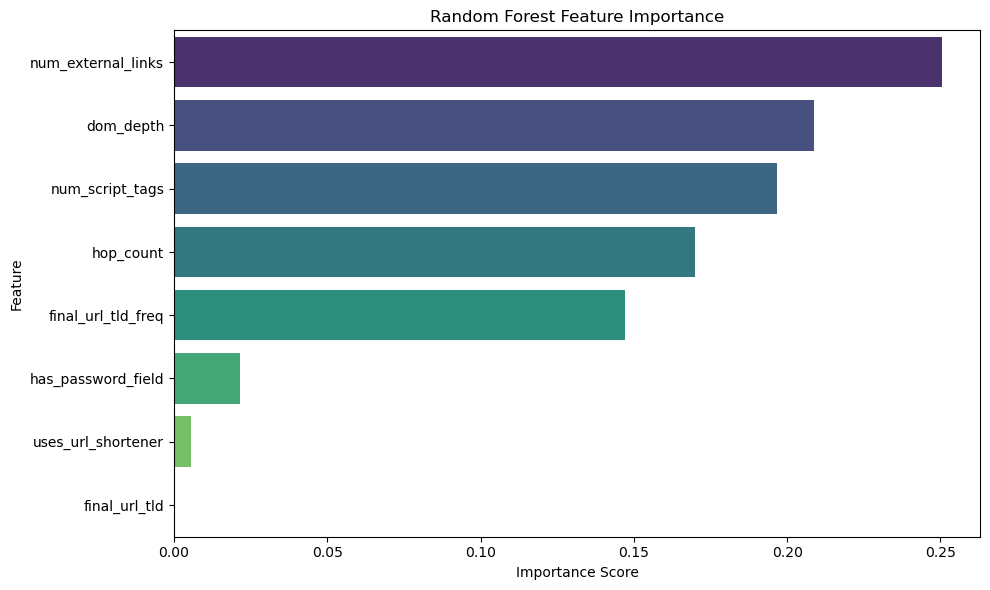

In [98]:
feature_names = X.columns

# 3. Extract Importance
importances = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- Feature Importance ---")
print(importances)

# 4. Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importances, x='importance', y='feature', palette='viridis')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [73]:
X_train

,hop_count,uses_url_shortener,num_script_tags,has_password_field,num_external_links,dom_depth,final_url_tld_freq
1482,1,0,19,0,62,31,715
1877,0,0,3,0,0,4,26
1796,0,0,6,0,0,14,715
1624,1,0,30,0,58,27,715
1660,0,0,1,0,0,6,715
...,...,...,...,...,...,...,...
1686,1,0,30,0,37,23,715
1763,1,0,6,0,3,11,1
1825,0,0,1,0,0,5,715
1377,1,0,9,0,0,3,19


In [75]:
df_clean

,label,hop_count,uses_url_shortener,num_script_tags,has_password_field,num_external_links,dom_depth,final_url_tld_freq
0,benign,1,0,15,0,62,13,9
1,benign,0,0,50,0,0,7,26
2,benign,1,0,16,0,14,20,715
3,phishing,0,0,-1,-1,-1,-1,3
6,phishing,0,0,20,0,409,23,3
...,...,...,...,...,...,...,...,...
2010,benign,0,0,4,0,0,4,715
2012,phishing,0,0,-1,-1,-1,-1,715
2013,phishing,0,0,-1,-1,-1,-1,17
2016,phishing,0,0,-1,-1,-1,-1,37


original_url             0
label                    0
hop_count                0
final_domain_age_days    0
uses_url_shortener       0
final_url_tld            0
num_script_tags          0
has_password_field       0
num_external_links       0
dom_depth                0
status                   0
dtype: int64

In [118]:
df.describe()

,hop_count,final_domain_age_days,uses_url_shortener,num_script_tags,has_password_field,num_external_links,dom_depth
count,2020.000000,2020.0,2020.000000,2020.000000,2020.000000,2020.00000,2020.000000
mean,0.029703,-1.0,0.002475,8.732673,-0.520792,11.39604,6.408416
std,1.094861,0.0,0.049703,20.306635,0.536035,48.87299,9.939890
min,-1.000000,-1.0,0.000000,-1.000000,-1.000000,-1.00000,-1.000000
25%,-1.000000,-1.0,0.000000,-1.000000,-1.000000,-1.00000,-1.000000
50%,0.000000,-1.0,0.000000,-1.000000,-1.000000,-1.00000,-1.000000
75%,1.000000,-1.0,0.000000,9.000000,0.000000,3.00000,13.000000
max,9.000000,-1.0,1.000000,269.000000,1.000000,916.00000,51.000000
